In [17]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:
# téléchargement du dataset
train_df = pd.read_csv("train.csv")
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

In [3]:
# sélection des features pertinentes
X = train_df.drop(columns=['season', 'atemp', 'casual', 'registered', 'count'])  
y = train_df[['casual', 'registered', 'count']]
X["month_id"] = X.datetime.dt.month + 12*(X.datetime.dt.year==2012)
X["hour_id"] = X.datetime.dt.hour

In [4]:
X

,datetime,holiday,workingday,weather,temp,humidity,windspeed,month_id,hour_id
0,2011-01-01 00:00:00,0,0,1,9.84,81,0.0000,1,0
1,2011-01-01 01:00:00,0,0,1,9.02,80,0.0000,1,1
2,2011-01-01 02:00:00,0,0,1,9.02,80,0.0000,1,2
3,2011-01-01 03:00:00,0,0,1,9.84,75,0.0000,1,3
4,2011-01-01 04:00:00,0,0,1,9.84,75,0.0000,1,4
...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,15.58,50,26.0027,24,19
10882,2012-12-19 20:00:00,0,1,1,14.76,57,15.0013,24,20
10883,2012-12-19 21:00:00,0,1,1,13.94,61,15.0013,24,21
10884,2012-12-19 22:00:00,0,1,1,13.94,61,6.0032,24,22


In [5]:
# sépare les données en un jeu de test et un jeu de train (20% de test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# features numériques
numeric_features = ['temp', 'humidity', 'windspeed']

# features catégoriques destinées à être one-hot encoded
binary_features = ['holiday', 'workingday']
one_hot_features = ['weather', 'month_id', 'hour_id']
categorical_features = binary_features + one_hot_features


In [6]:
# on crée un pipeline qui construit le vecteur input à donner au modèle en entrée

# on normalise les valeurs numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

# on laisse les features binaires inchangées
binary_transformer = 'passthrough'

# on transforme en one hot les features catégoriques
one_hot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features
])

# on combine les pipelines pour les données numériques et catégoriques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('one_hot', one_hot_transformer, one_hot_features)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor)])
clf.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed']),
                                                 ('bin', 'passthrough',
                                                  ['holiday', 'workingday']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weather', 'month_id',
                                                   'hour_id'])]))])

In [7]:
# on transforme les données avec la pipeline puis on les met sous la forme de torch.tensor pour le modèle
Xtr_tensor = torch.tensor(clf.transform(X_train).toarray(), dtype=torch.float32)
ytr_tensor = torch.tensor(y_train.values/500.0, dtype=torch.float32)

Xtest_tensor = torch.tensor(clf.transform(X_test).toarray(), dtype=torch.float32)
ytest_tensor = torch.tensor(y_test.values/500.0, dtype=torch.float32)

# on crée un DataLoader afin de charger plus facilement les données d'entraînement lors de l'apprentissage du modèle
train_dataset = TensorDataset(Xtr_tensor, ytr_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [76]:
# on crée ici le modèle linéaire
class RegressionLineaireModele(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        return self.relu(self.linear(x))

In [77]:
def RMLSE(output, target):
    log_diff = torch.log(output+1) - torch.log(target+1)
    return torch.sqrt(torch.mean(log_diff**2))

step: 0 | train_loss: 3.2339 | test_loss: 3.3084
step: 200 | train_loss: 1.5167 | test_loss: 1.5196
step: 400 | train_loss: 1.1524 | test_loss: 1.1237
step: 600 | train_loss: 0.8328 | test_loss: 0.9441
step: 800 | train_loss: 0.7362 | test_loss: 0.8577
step: 1000 | train_loss: 0.8360 | test_loss: 0.8134
step: 1200 | train_loss: 0.7025 | test_loss: 0.7952
step: 1400 | train_loss: 0.7617 | test_loss: 0.7901
step: 1600 | train_loss: 0.8084 | test_loss: 0.7831
step: 1800 | train_loss: 0.8179 | test_loss: 0.8060


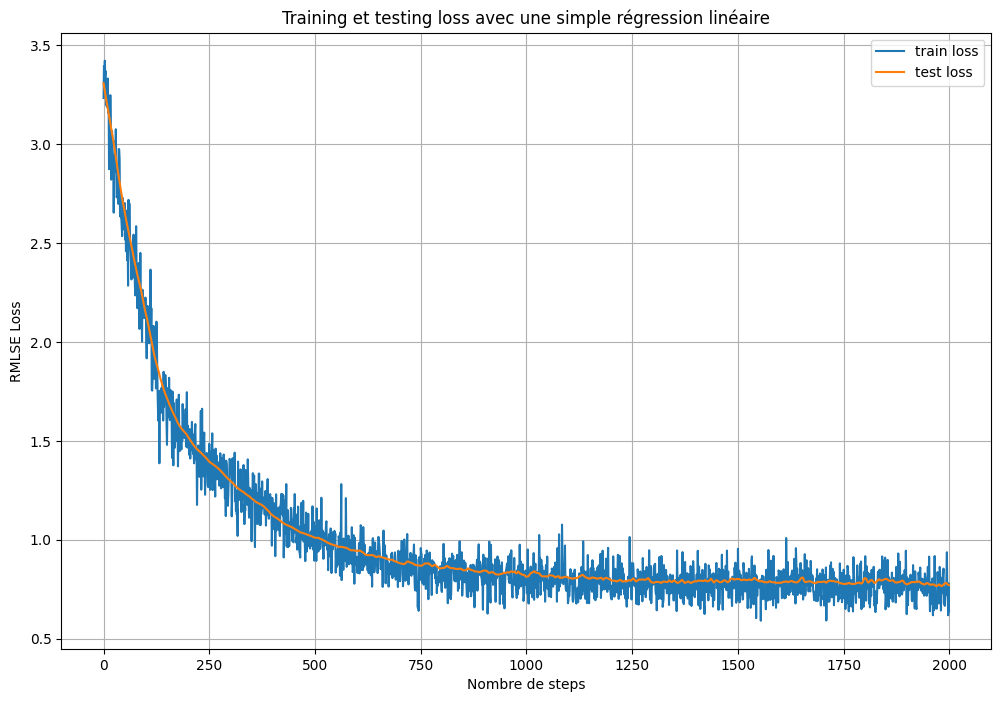

In [79]:
nb_steps = 2000 # nombre de steps d'entraînement
model = RegressionLineaireModele(input_size=Xtr_tensor.shape[-1], output_size=ytr_tensor.shape[-1])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
train_losses = []
test_losses = []

# boucle d'entraînement du modèle
for step in range(nb_steps):
    inputs, targets = next(iter(train_loader))

    optimizer.zero_grad()
    outputs = model(inputs) # calcule les prédictions du modèle
    # loss = torch.mean((outputs-targets)**2) # calcule la loss
    loss = RMLSE(500.0*outputs, 500.0*targets)
    loss.backward() # calcule le gradient de la loss par rapport aux paramètres
    optimizer.step() # met à jour les paraùètres

    train_losses.append(loss.item())

    # calcule la loss sur le jeu de test pour évaluer la généralisabilité du modèle
    with torch.no_grad():
        test_outputs = model(Xtest_tensor)
        # test_loss = torch.mean((test_outputs-ytest_tensor)**2)
        test_loss = RMLSE(500.0*test_outputs, 500.0*ytest_tensor)
        test_losses.append(test_loss.item())

    if step%200 == 0:
        print(f"step: {step} | train_loss: {loss.item():.4f} | test_loss: {test_loss.item():.4f}")

# affiche la figure
plt.figure(figsize=(12,8))
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("Nombre de steps")
plt.ylabel("RMLSE Loss")
plt.title("Training et testing loss avec une simple régression linéaire")
plt.legend()
plt.grid()
plt.show()

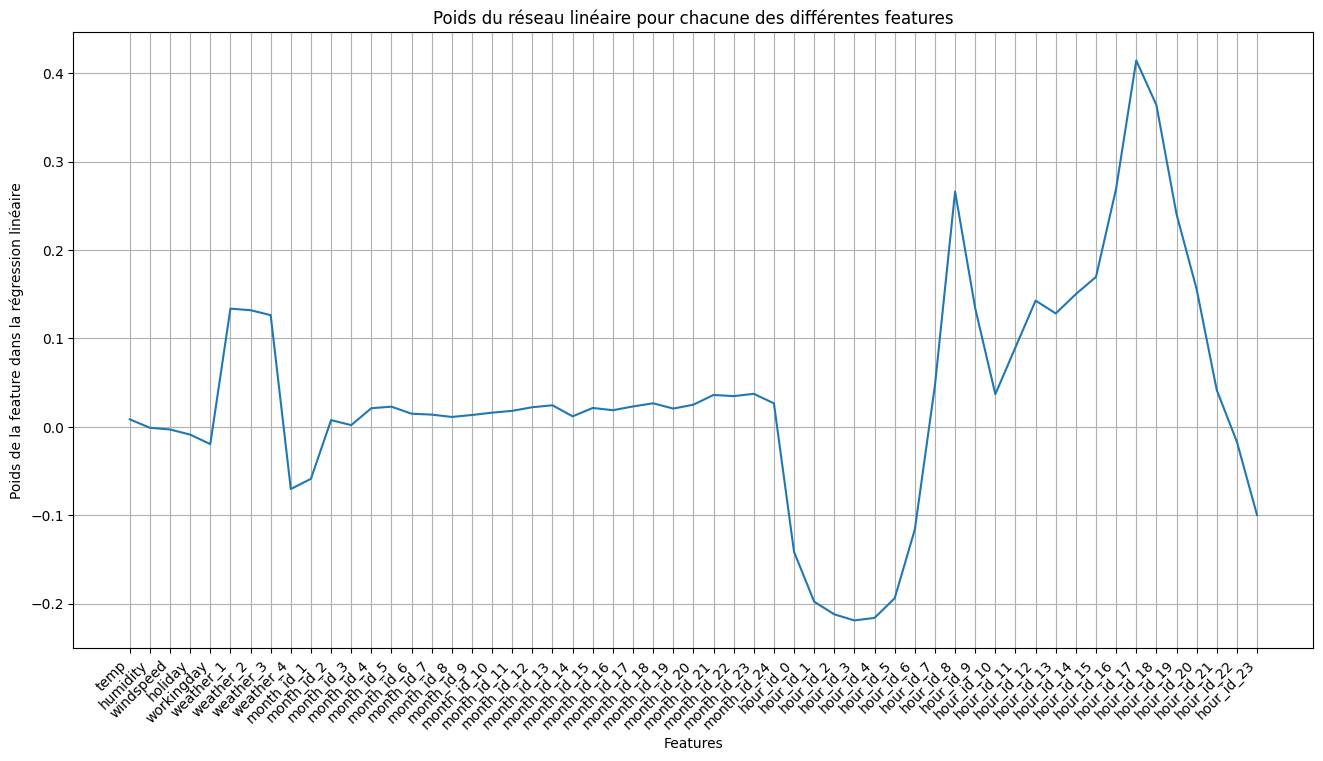

In [80]:
# plot des poids associés à chacune des différentes features

features_names = preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +\
                    preprocessor.named_transformers_['bin'].get_feature_names_out().tolist() +\
                    preprocessor.named_transformers_['one_hot'].get_feature_names_out().tolist() 

plt.figure(figsize=(16,8))
plt.plot(model.linear.weight[2,:].tolist())
plt.xticks(ticks=range(len(features_names)), labels=features_names, rotation=45, ha="right")
plt.grid()
plt.title("Poids du réseau linéaire pour chacune des différentes features")
plt.xlabel("Features")
plt.ylabel("Poids de la feature dans la régression linéaire")
plt.show()

In [65]:
# téléchargement du dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

# réunion des deux DataFrames
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])
combined_df.sort_values(by="datetime", inplace=True)

In [66]:
# sélection des features pertinentes
X = combined_df.drop(columns=['season', 'atemp', 'casual', 'registered', 'count'])  
X["month_id"] = X.datetime.dt.month + 12*(X.datetime.dt.year==2012)
X["hour_id"] = X.datetime.dt.hour
X_tensor = torch.tensor(clf.transform(X).toarray(), dtype=torch.float32)
outputs = model(X_tensor)[:, 2]*500.0

[]

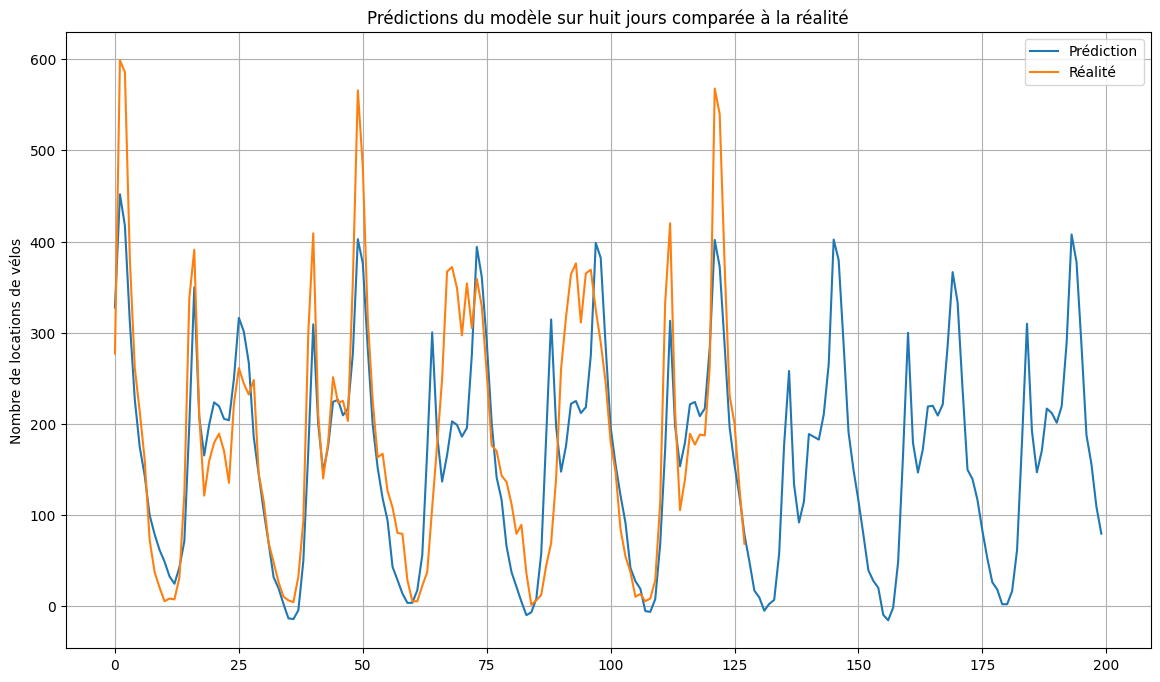

In [67]:
debut = 6050
nb_values = 200
plt.figure(figsize=(14,8))
plt.plot(outputs[debut:debut+nb_values].tolist(), label="Prédiction")
plt.plot(combined_df['count'][debut:debut+nb_values].tolist(), label="Réalité")
plt.grid()
plt.ylabel("Nombre de locations de vélos")
plt.legend()
plt.title('Prédictions du modèle sur huit jours comparée à la réalité')
plt.plot()

In [58]:
def get_submission(model, title):
    test_df = pd.read_csv("test.csv")
    test_df['datetime'] = pd.to_datetime(test_df['datetime'])
    X = test_df.drop(columns=['season', 'atemp'])  
    X["month_id"] = X.datetime.dt.month + 12*(X.datetime.dt.year==2012)
    X["hour_id"] = X.datetime.dt.hour
    X_tensor = torch.tensor(clf.transform(X).toarray(), dtype=torch.float32)

    predictions = model(X_tensor)[:,2]*500.0
    predictions.shape

    submission_df = X.copy()
    submission_df.drop(columns=['holiday', 'workingday', 'weather', 'temp', 'humidity',
        'windspeed', 'month_id', 'hour_id'], inplace=True)
    submission_df["count"] = torch.relu(predictions).tolist()
    submission_df.to_csv(f"submission_{title}.csv", index=False)

In [59]:
get_submission(model, "linear")